# Clustering Documents
Document clustering, also called text clustering, is a cluster analysis on textual documents. One of the typical usages would be document
management.

In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs

from sklearn import feature_extraction
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

In [4]:
#Lets use the same complaint dataset we use for classification
Data = pd.read_csv("complaints.csv")

In [6]:
#selecting required columns and rows
Data = Data[['Consumer complaint narrative']]
Data = Data[pd.notnull(Data['Consumer complaint narrative'])]
# lets do the clustering for just 200 documents. Its easier to interpret.
Data_sample=Data.sample(200)

In [9]:
# Remove unwanted symbol
Data_sample['Consumer complaint narrative'] = Data_sample['Consumer complaint narrative'].str.replace('XXXX','')
# Convert dataframe to list
complaints = Data_sample['Consumer complaint narrative'].tolist()
# create the rank of documents – we will use it later
ranks = []
for i in range(1, len(complaints)+1):
    ranks.append(i)

In [10]:
# Stop Words
stopwords = nltk.corpus.stopwords.words('english')
# Load 'stemmer'
stemmer = SnowballStemmer("english")

In [13]:
# Functions for sentence tokenizer, to remove numeric tokens and raw #punctuation
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2, stop_words='english', use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [15]:
#fit the vectorizer to data
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)
terms = tfidf_vectorizer.get_feature_names()
print(tfidf_matrix.shape)

C:\Users\baban\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(200, 30)


In [16]:
#Import Kmeans
from sklearn.cluster import KMeans

In [17]:
# Define number of clusters
num_clusters = 6

#Running clustering algorithm
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

#final clusters
clusters = km.labels_.tolist()


In [18]:
complaints_data = { 'rank': ranks, 'complaints': complaints, 'cluster': clusters }
frame = pd.DataFrame(complaints_data, index = [clusters] , columns = ['rank', 'cluster'])



#number of docs per cluster
frame['cluster'].value_counts()

2    52
0    47
5    27
4    25
1    25
3    24
Name: cluster, dtype: int64

# Identify cluster behavior

Identify which are the top 5 words that are nearest to the cluster centroid.

In [19]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in complaints:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [20]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized},index = totalvocab_stemmed)
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]


In [25]:
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
          print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')

Cluster 0 words: b'report', b'credit', b'information', b'credit', b'company', b'accounts',Cluster 1 words: b'xx/xx/', b'accounts', b'report', b'credit', b'day', b'contacting',Cluster 2 words: b'cards', b'payments', b'did', b'told', b'time', b'requested',Cluster 3 words: b'debt', b'collect', b'company', b'credit', b'stated', b'report',Cluster 4 words: b'accounts', b'report', b'removed', b'credit', b'information', b'company',Cluster 5 words: b'loan', b'payments', b'monthly', b'company', b'pay', b'time',

# Plot the clusters on a 2D graph

In [26]:
#Similarity
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

In [28]:
# Convert two components as we're plotting points in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed",random_state=1)
pos = mds.fit_transform(similarity_distance) # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [29]:
#Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3',3: '#e7298a', 4: '#66a61e', 5: '#D2691E'}

In [30]:
#set up cluster names using a dict
cluster_names = {0: 'property, based, assist',
 1: 'business, card',
 2: 'authorized, approved, believe',
 3: 'agreement, application,business',
 4: 'closed, applied, additional',
 5: 'applied, card'}

In [31]:
# Finally plot it
%matplotlib inline
#Create data frame that has the result of the MDS and the cluster
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df.groupby('label')

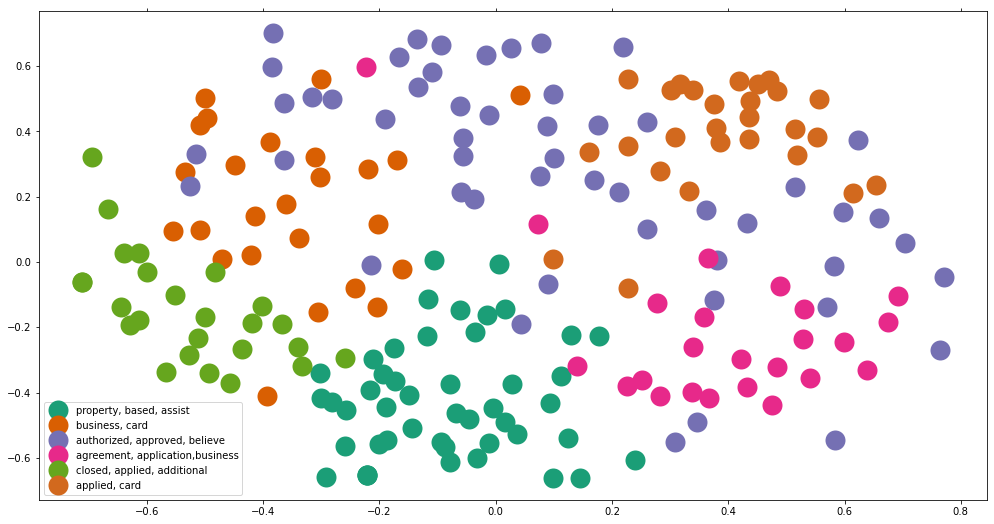

In [33]:
# Set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20,label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
                   axis= 'x',
                   which='both',
                   bottom='off',
                   top='off',
                   labelbottom='off')
    ax.tick_params(\
                   axis= 'y',
                   which='both',
                   left='off',
                   top='off',
                   labelleft='off')
    ax.legend(numpoints=1)
            
plt.show()